# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

2023-10-16 20:06:51.414599: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 20:06:52.048231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 50
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [6]:
tokenizer = get_tokenizer("basic_english")

In [7]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

In [8]:

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  2049990
Valid Tokens:  214417
Test Tokens:  241859
Total number of tokens: 2506266


In [9]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 28785


## Custom Dataset

In [10]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:
train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model
    Non-monotonically Triggered ASGD (NT-ASGD)
    https://github.com/ahmetumutdurmus/awd-lstm/blob/master/ntasgd.py

In [29]:
class NTASGD(optim.Optimizer):
    def __init__(self, params, lr=1, n=5, weight_decay=0, fine_tuning=False):
        t0 = 0 if fine_tuning else 10e7
        defaults = dict(lr=lr, n=n, weight_decay=weight_decay, fine_tuning=fine_tuning, t0=t0, t=0, logs=[])
        super(NTASGD, self).__init__(params, defaults)

    def check(self, v):
        for group in self.param_groups:
            #Training
            if (not group['fine_tuning'] and group['t0'] == 10e7) or (group['fine_tuning']):
                if group['t'] > group['n'] and v > min(group['logs'][:-group['n']]):
                    group['t0'] = self.state[next(iter(group['params']))]['step']
                    print("Non-monotonic condition is triggered!")
                    return True
                group['logs'].append(v)
                group['t'] += 1

    def lr(self, lr):
        for group in self.param_groups:
            group['lr'] = lr
                               
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]
                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['mu'] = 1
                    state['ax'] = torch.zeros_like(p.data)
                state['step'] += 1
                # update parameter
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)
                
                p.data.add_(-group['lr'], grad)
                # averaging
                if state['mu'] != 1:
                    state['ax'].add_(p.data.sub(state['ax']).mul(state['mu']))
                else:
                    state['ax'].copy_(p.data)
                # update mu
                state['mu'] = 1 / max(1, state['step'] - group['t0'])

In [14]:
class H2HLSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, hidden = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, hidden = self.rnn2(output,hidden)
    output = self.dropout2(output)
    
    output, hidden = self.rnn3(output,hidden)
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [15]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [16]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [17]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H2HLSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 34.825785



H2HLSTM(
  (embedding): Embedding(28785, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=28785, bias=True)
)

## Learning Loop

In [32]:
lr = 1
wd = 1e-5
optimizer = NTASGD(model.parameters(), lr=lr, weight_decay=wd)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [33]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 1640/1640 [04:42<00:00,  5.81batch/s, loss=6.31, perplexity=568] 


Valid: Loss = 5.936 Perplexity= 386.5, LR = 1
Model Saved!



Epoch 1: 100%|██████████| 1640/1640 [04:43<00:00,  5.78batch/s, loss=6.02, perplexity=422]


Valid: Loss = 5.765 Perplexity= 326.2, LR = 1
Model Saved!



Epoch 2: 100%|██████████| 1640/1640 [04:44<00:00,  5.76batch/s, loss=5.84, perplexity=355]


Valid: Loss = 5.661 Perplexity= 294.4, LR = 1
Model Saved!



Epoch 3: 100%|██████████| 1640/1640 [04:44<00:00,  5.76batch/s, loss=5.7, perplexity=308] 


Valid: Loss = 5.526 Perplexity= 257.3, LR = 1
Model Saved!



Epoch 4: 100%|██████████| 1640/1640 [04:44<00:00,  5.77batch/s, loss=5.56, perplexity=268]


Valid: Loss = 5.466 Perplexity= 242.8, LR = 1
Model Saved!



Epoch 5: 100%|██████████| 1640/1640 [04:44<00:00,  5.76batch/s, loss=5.44, perplexity=237]


Valid: Loss = 5.348 Perplexity= 216.0, LR = 1
Model Saved!



Epoch 6: 100%|██████████| 1640/1640 [04:45<00:00,  5.75batch/s, loss=5.34, perplexity=215]


Valid: Loss = 5.301 Perplexity= 206.2, LR = 1
Model Saved!



Epoch 7: 100%|██████████| 1640/1640 [04:44<00:00,  5.76batch/s, loss=5.24, perplexity=196]


Valid: Loss = 5.219 Perplexity= 189.9, LR = 1
Model Saved!



Epoch 8: 100%|██████████| 1640/1640 [04:45<00:00,  5.75batch/s, loss=5.15, perplexity=178]


Valid: Loss = 5.17 Perplexity= 181.3, LR = 1
Model Saved!



Epoch 9: 100%|██████████| 1640/1640 [04:46<00:00,  5.73batch/s, loss=5.07, perplexity=164]


Valid: Loss = 5.086 Perplexity= 166.9, LR = 1
Model Saved!



Epoch 10: 100%|██████████| 1640/1640 [04:46<00:00,  5.73batch/s, loss=4.99, perplexity=151]


Valid: Loss = 5.027 Perplexity= 157.3, LR = 1
Model Saved!



Epoch 11: 100%|██████████| 1640/1640 [04:46<00:00,  5.73batch/s, loss=4.91, perplexity=140]


Valid: Loss = 4.954 Perplexity= 146.2, LR = 1
Model Saved!



Epoch 12: 100%|██████████| 1640/1640 [04:46<00:00,  5.72batch/s, loss=4.83, perplexity=130]


Valid: Loss = 4.909 Perplexity= 140.0, LR = 1
Model Saved!



Epoch 13: 100%|██████████| 1640/1640 [04:46<00:00,  5.73batch/s, loss=4.75, perplexity=120]


Valid: Loss = 4.827 Perplexity= 129.1, LR = 1
Model Saved!



Epoch 14: 100%|██████████| 1640/1640 [04:46<00:00,  5.72batch/s, loss=4.68, perplexity=111]


Valid: Loss = 4.775 Perplexity= 122.4, LR = 1
Model Saved!



Epoch 15: 100%|██████████| 1640/1640 [04:47<00:00,  5.71batch/s, loss=4.62, perplexity=105]


Valid: Loss = 4.745 Perplexity= 118.9, LR = 1
Model Saved!



Epoch 16: 100%|██████████| 1640/1640 [04:43<00:00,  5.79batch/s, loss=4.56, perplexity=99]  


Valid: Loss = 4.707 Perplexity= 114.6, LR = 1
Model Saved!



Epoch 17: 100%|██████████| 1640/1640 [04:40<00:00,  5.84batch/s, loss=4.51, perplexity=93.9]


Valid: Loss = 4.66 Perplexity= 109.3, LR = 1
Model Saved!



Epoch 18: 100%|██████████| 1640/1640 [04:32<00:00,  6.03batch/s, loss=4.46, perplexity=89.3]


Valid: Loss = 4.623 Perplexity= 105.3, LR = 1
Model Saved!



Epoch 19: 100%|██████████| 1640/1640 [04:47<00:00,  5.70batch/s, loss=4.4, perplexity=84.8] 


Valid: Loss = 4.585 Perplexity= 101.5, LR = 1
Model Saved!



Epoch 20: 100%|██████████| 1640/1640 [04:47<00:00,  5.71batch/s, loss=4.36, perplexity=80.9]


Valid: Loss = 4.549 Perplexity= 97.98, LR = 1
Model Saved!



Epoch 21: 100%|██████████| 1640/1640 [04:50<00:00,  5.64batch/s, loss=4.31, perplexity=77.3]


Valid: Loss = 4.506 Perplexity= 93.79, LR = 1
Model Saved!



Epoch 22: 100%|██████████| 1640/1640 [04:39<00:00,  5.87batch/s, loss=4.26, perplexity=73.6]


Valid: Loss = 4.497 Perplexity= 93.13, LR = 1
Model Saved!



Epoch 23: 100%|██████████| 1640/1640 [04:33<00:00,  5.99batch/s, loss=4.22, perplexity=70.4]


Valid: Loss = 4.466 Perplexity= 90.15, LR = 1
Model Saved!



Epoch 24: 100%|██████████| 1640/1640 [04:39<00:00,  5.87batch/s, loss=4.18, perplexity=67.7]


Valid: Loss = 4.427 Perplexity= 86.87, LR = 1
Model Saved!



Epoch 25: 100%|██████████| 1640/1640 [04:22<00:00,  6.25batch/s, loss=4.14, perplexity=65]  


Valid: Loss = 4.389 Perplexity= 83.54, LR = 1
Model Saved!



Epoch 26: 100%|██████████| 1640/1640 [04:36<00:00,  5.93batch/s, loss=4.1, perplexity=62.4] 


Valid: Loss = 4.364 Perplexity= 81.52, LR = 1
Model Saved!



Epoch 27: 100%|██████████| 1640/1640 [04:31<00:00,  6.04batch/s, loss=4.06, perplexity=60]  


Valid: Loss = 4.337 Perplexity= 79.31, LR = 1
Model Saved!



Epoch 28: 100%|██████████| 1640/1640 [04:33<00:00,  6.00batch/s, loss=4.02, perplexity=57.5]


Valid: Loss = 4.283 Perplexity= 75.15, LR = 1
Model Saved!



Epoch 29: 100%|██████████| 1640/1640 [04:27<00:00,  6.12batch/s, loss=3.98, perplexity=55.2]


Valid: Loss = 4.271 Perplexity= 74.21, LR = 1
Model Saved!



Epoch 30: 100%|██████████| 1640/1640 [04:28<00:00,  6.11batch/s, loss=3.94, perplexity=53.2]


Valid: Loss = 4.239 Perplexity= 72.0, LR = 1
Model Saved!



Epoch 31: 100%|██████████| 1640/1640 [04:45<00:00,  5.74batch/s, loss=3.9, perplexity=51.2] 


Valid: Loss = 4.208 Perplexity= 69.72, LR = 1
Model Saved!



Epoch 32: 100%|██████████| 1640/1640 [04:44<00:00,  5.76batch/s, loss=3.86, perplexity=49.3]


Valid: Loss = 4.159 Perplexity= 66.43, LR = 1
Model Saved!



Epoch 33: 100%|██████████| 1640/1640 [04:22<00:00,  6.24batch/s, loss=3.83, perplexity=47.7]


Valid: Loss = 4.143 Perplexity= 65.34, LR = 1
Model Saved!



Epoch 34: 100%|██████████| 1640/1640 [04:31<00:00,  6.04batch/s, loss=3.79, perplexity=46]  


Valid: Loss = 4.122 Perplexity= 64.1, LR = 1
Model Saved!



Epoch 35: 100%|██████████| 1640/1640 [04:45<00:00,  5.75batch/s, loss=3.76, perplexity=44.7]


Valid: Loss = 4.092 Perplexity= 62.2, LR = 1
Model Saved!



Epoch 36: 100%|██████████| 1640/1640 [04:45<00:00,  5.75batch/s, loss=3.73, perplexity=43.1]


Valid: Loss = 4.058 Perplexity= 60.07, LR = 1
Model Saved!



Epoch 37: 100%|██████████| 1640/1640 [04:46<00:00,  5.73batch/s, loss=3.7, perplexity=41.9] 


Valid: Loss = 4.036 Perplexity= 58.78, LR = 1
Model Saved!



Epoch 38: 100%|██████████| 1640/1640 [04:46<00:00,  5.73batch/s, loss=3.66, perplexity=40.4]


Valid: Loss = 4.008 Perplexity= 57.13, LR = 1
Model Saved!



Epoch 39: 100%|██████████| 1640/1640 [04:46<00:00,  5.72batch/s, loss=3.64, perplexity=39.3]


Valid: Loss = 4.019 Perplexity= 57.84, LR = 1



Epoch 40: 100%|██████████| 1640/1640 [04:54<00:00,  5.57batch/s, loss=4.42, perplexity=85.8]


Valid: Loss = 4.365 Perplexity= 81.52, LR = 0.5



Epoch 41: 100%|██████████| 1640/1640 [04:50<00:00,  5.65batch/s, loss=4.08, perplexity=61.1]


Valid: Loss = 4.24 Perplexity= 72.21, LR = 0.25



Epoch 42: 100%|██████████| 1640/1640 [04:53<00:00,  5.58batch/s, loss=3.8, perplexity=46.2] 


Valid: Loss = 4.068 Perplexity= 60.83, LR = 0.125



Epoch 43: 100%|██████████| 1640/1640 [04:53<00:00,  5.59batch/s, loss=3.66, perplexity=40.3]


Valid: Loss = 3.953 Perplexity= 54.16, LR = 0.0625
Model Saved!



Epoch 44: 100%|██████████| 1640/1640 [04:58<00:00,  5.50batch/s, loss=3.63, perplexity=39.2]


Valid: Loss = 3.934 Perplexity= 53.13, LR = 0.0625
Model Saved!



Epoch 45: 100%|██████████| 1640/1640 [05:07<00:00,  5.33batch/s, loss=3.6, perplexity=37.9] 


Valid: Loss = 3.897 Perplexity= 51.17, LR = 0.0625
Model Saved!



Epoch 46: 100%|██████████| 1640/1640 [05:11<00:00,  5.26batch/s, loss=3.57, perplexity=36.7]


Valid: Loss = 3.887 Perplexity= 50.69, LR = 0.0625
Model Saved!



Epoch 47: 100%|██████████| 1640/1640 [05:09<00:00,  5.30batch/s, loss=3.55, perplexity=36]  


Valid: Loss = 3.855 Perplexity= 49.09, LR = 0.0625
Model Saved!



Epoch 48: 100%|██████████| 1640/1640 [05:12<00:00,  5.25batch/s, loss=3.53, perplexity=35.4]


Valid: Loss = 3.86 Perplexity= 49.32, LR = 0.0625



Epoch 49: 100%|██████████| 1640/1640 [04:58<00:00,  5.49batch/s, loss=3.49, perplexity=33.9]


Valid: Loss = 3.805 Perplexity= 46.75, LR = 0.03125
Model Saved!



Epoch 50: 100%|██████████| 1640/1640 [04:28<00:00,  6.12batch/s, loss=3.47, perplexity=33.1]


Valid: Loss = 3.775 Perplexity= 45.32, LR = 0.03125
Model Saved!



Epoch 51: 100%|██████████| 1640/1640 [04:52<00:00,  5.61batch/s, loss=3.44, perplexity=32.2]


Valid: Loss = 3.751 Perplexity= 44.24, LR = 0.03125
Model Saved!



Epoch 52: 100%|██████████| 1640/1640 [04:52<00:00,  5.61batch/s, loss=3.42, perplexity=31.6]


Valid: Loss = 3.735 Perplexity= 43.55, LR = 0.03125
Model Saved!



Epoch 53: 100%|██████████| 1640/1640 [04:52<00:00,  5.60batch/s, loss=3.4, perplexity=31]   


Valid: Loss = 3.713 Perplexity= 42.57, LR = 0.03125
Model Saved!



Epoch 54: 100%|██████████| 1640/1640 [04:52<00:00,  5.61batch/s, loss=3.38, perplexity=30.5]


Valid: Loss = 3.718 Perplexity= 42.85, LR = 0.03125



Epoch 55: 100%|██████████| 1640/1640 [04:51<00:00,  5.62batch/s, loss=3.38, perplexity=30.2]


Valid: Loss = 3.68 Perplexity= 41.23, LR = 0.015625
Model Saved!



Epoch 56: 100%|██████████| 1640/1640 [04:27<00:00,  6.13batch/s, loss=3.36, perplexity=29.9]


Valid: Loss = 3.666 Perplexity= 40.59, LR = 0.015625
Model Saved!



Epoch 57: 100%|██████████| 1640/1640 [04:21<00:00,  6.26batch/s, loss=3.38, perplexity=30.3]


Valid: Loss = 3.653 Perplexity= 40.08, LR = 0.015625
Model Saved!



Epoch 58: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.36, perplexity=29.8]


Valid: Loss = 3.645 Perplexity= 39.73, LR = 0.015625
Model Saved!



Epoch 59: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.36, perplexity=29.9]


Valid: Loss = 3.642 Perplexity= 39.61, LR = 0.015625
Model Saved!



Epoch 60: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.55, perplexity=37.1]


Valid: Loss = 3.791 Perplexity= 46.05, LR = 0.015625



Epoch 61: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.34, perplexity=29.4]


Valid: Loss = 3.591 Perplexity= 37.64, LR = 0.0078125
Model Saved!



Epoch 62: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.33, perplexity=29.1]


Valid: Loss = 3.574 Perplexity= 36.97, LR = 0.0078125
Model Saved!



Epoch 63: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.32, perplexity=28.6]


Valid: Loss = 3.572 Perplexity= 36.89, LR = 0.0078125
Model Saved!



Epoch 64: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.31, perplexity=28.3]


Valid: Loss = 3.565 Perplexity= 36.64, LR = 0.0078125
Model Saved!



Epoch 65: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.3, perplexity=28.1] 


Valid: Loss = 3.563 Perplexity= 36.58, LR = 0.0078125
Model Saved!



Epoch 66: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.29, perplexity=27.8]


Valid: Loss = 3.555 Perplexity= 36.28, LR = 0.0078125
Model Saved!



Epoch 67: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.29, perplexity=27.9]


Valid: Loss = 3.565 Perplexity= 36.65, LR = 0.0078125



Epoch 68: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.28, perplexity=27.6]


Valid: Loss = 3.522 Perplexity= 35.09, LR = 0.00390625
Model Saved!



Epoch 69: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.28, perplexity=27.6]


Valid: Loss = 3.516 Perplexity= 34.88, LR = 0.00390625
Model Saved!



Epoch 70: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.27, perplexity=27.4]


Valid: Loss = 3.515 Perplexity= 34.84, LR = 0.00390625
Model Saved!



Epoch 71: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.28, perplexity=27.5]


Valid: Loss = 3.501 Perplexity= 34.34, LR = 0.00390625
Model Saved!



Epoch 72: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.28, perplexity=27.5]


Valid: Loss = 3.496 Perplexity= 34.16, LR = 0.00390625
Model Saved!



Epoch 73: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.28, perplexity=27.6]


Valid: Loss = 3.502 Perplexity= 34.37, LR = 0.00390625



Epoch 74: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.27, perplexity=27.3]


Valid: Loss = 3.472 Perplexity= 33.35, LR = 0.001953125
Model Saved!



Epoch 75: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.26, perplexity=27.1]


Valid: Loss = 3.467 Perplexity= 33.18, LR = 0.001953125
Model Saved!



Epoch 76: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.26, perplexity=27]  


Valid: Loss = 3.466 Perplexity= 33.16, LR = 0.001953125
Model Saved!



Epoch 77: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.26, perplexity=27]  


Valid: Loss = 3.469 Perplexity= 33.23, LR = 0.001953125



Epoch 78: 100%|██████████| 1640/1640 [04:20<00:00,  6.28batch/s, loss=3.26, perplexity=26.9]


Valid: Loss = 3.456 Perplexity= 32.81, LR = 0.0009765625
Model Saved!



Epoch 79: 100%|██████████| 1640/1640 [04:20<00:00,  6.28batch/s, loss=3.26, perplexity=26.9]


Valid: Loss = 3.455 Perplexity= 32.78, LR = 0.0009765625
Model Saved!



Epoch 80: 100%|██████████| 1640/1640 [04:20<00:00,  6.28batch/s, loss=3.25, perplexity=26.8]


Valid: Loss = 3.453 Perplexity= 32.72, LR = 0.0009765625
Model Saved!



Epoch 81: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.25, perplexity=26.8]


Valid: Loss = 3.451 Perplexity= 32.66, LR = 0.0009765625
Model Saved!



Epoch 82: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.25, perplexity=26.7]


Valid: Loss = 3.452 Perplexity= 32.7, LR = 0.0009765625



Epoch 83: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.25, perplexity=26.7]


Valid: Loss = 3.448 Perplexity= 32.54, LR = 0.00048828125
Model Saved!



Epoch 84: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.25, perplexity=26.7]


Valid: Loss = 3.446 Perplexity= 32.5, LR = 0.00048828125
Model Saved!



Epoch 85: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.25, perplexity=26.7]


Valid: Loss = 3.447 Perplexity= 32.52, LR = 0.00048828125



Epoch 86: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.25, perplexity=26.6]


Valid: Loss = 3.445 Perplexity= 32.46, LR = 0.000244140625
Model Saved!



Epoch 87: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.25, perplexity=26.6]


Valid: Loss = 3.445 Perplexity= 32.45, LR = 0.000244140625
Model Saved!



Epoch 88: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.25, perplexity=26.6]


Valid: Loss = 3.445 Perplexity= 32.44, LR = 0.000244140625
Model Saved!



Epoch 89: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.25, perplexity=26.6]


Valid: Loss = 3.444 Perplexity= 32.42, LR = 0.000244140625
Model Saved!



Epoch 90: 100%|██████████| 1640/1640 [04:20<00:00,  6.28batch/s, loss=3.25, perplexity=26.6]


Valid: Loss = 3.443 Perplexity= 32.41, LR = 0.000244140625
Model Saved!



Epoch 91: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.24, perplexity=26.6]


Valid: Loss = 3.443 Perplexity= 32.38, LR = 0.000244140625
Model Saved!



Epoch 92: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.24, perplexity=26.6]


Valid: Loss = 3.443 Perplexity= 32.38, LR = 0.000244140625



Epoch 93: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.24, perplexity=26.5]


Valid: Loss = 3.442 Perplexity= 32.36, LR = 0.0001220703125
Model Saved!



Epoch 94: 100%|██████████| 1640/1640 [04:20<00:00,  6.28batch/s, loss=3.24, perplexity=26.5]


Valid: Loss = 3.442 Perplexity= 32.36, LR = 0.0001220703125



Epoch 95: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.24, perplexity=26.6]


Valid: Loss = 3.442 Perplexity= 32.36, LR = 6.103515625e-05
Model Saved!



Epoch 96: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.24, perplexity=26.5]


Valid: Loss = 3.442 Perplexity= 32.35, LR = 6.103515625e-05
Model Saved!



Epoch 97: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.24, perplexity=26.6]


Valid: Loss = 3.441 Perplexity= 32.34, LR = 6.103515625e-05
Model Saved!



Epoch 98: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.24, perplexity=26.6]


Valid: Loss = 3.442 Perplexity= 32.36, LR = 6.103515625e-05



Epoch 99: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.24, perplexity=26.5]


Valid: Loss = 3.441 Perplexity= 32.33, LR = 3.0517578125e-05
Model Saved!



Epoch 100: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.24, perplexity=26.5]


Valid: Loss = 3.441 Perplexity= 32.33, LR = 3.0517578125e-05



Epoch 101: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.24, perplexity=26.5]


Valid: Loss = 3.441 Perplexity= 32.33, LR = 1.52587890625e-05
Model Saved!



Epoch 102: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.24, perplexity=26.5]


Valid: Loss = 3.441 Perplexity= 32.32, LR = 1.52587890625e-05
Model Saved!



Epoch 103: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.24, perplexity=26.5]


Valid: Loss = 3.441 Perplexity= 32.33, LR = 1.52587890625e-05



Epoch 104: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.24, perplexity=26.5]


Valid: Loss = 3.441 Perplexity= 32.33, LR = 7.62939453125e-06



Epoch 105: 100%|██████████| 1640/1640 [04:20<00:00,  6.28batch/s, loss=3.24, perplexity=26.5]


Valid: Loss = 3.441 Perplexity= 32.33, LR = 3.814697265625e-06



Epoch 106: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.24, perplexity=26.5]


Valid: Loss = 3.441 Perplexity= 32.33, LR = 1.9073486328125e-06



Epoch 107: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.24, perplexity=26.5]


Valid: Loss = 3.441 Perplexity= 32.32, LR = 9.5367431640625e-07
LR_DEC==3 , Finished


## Learning Curve

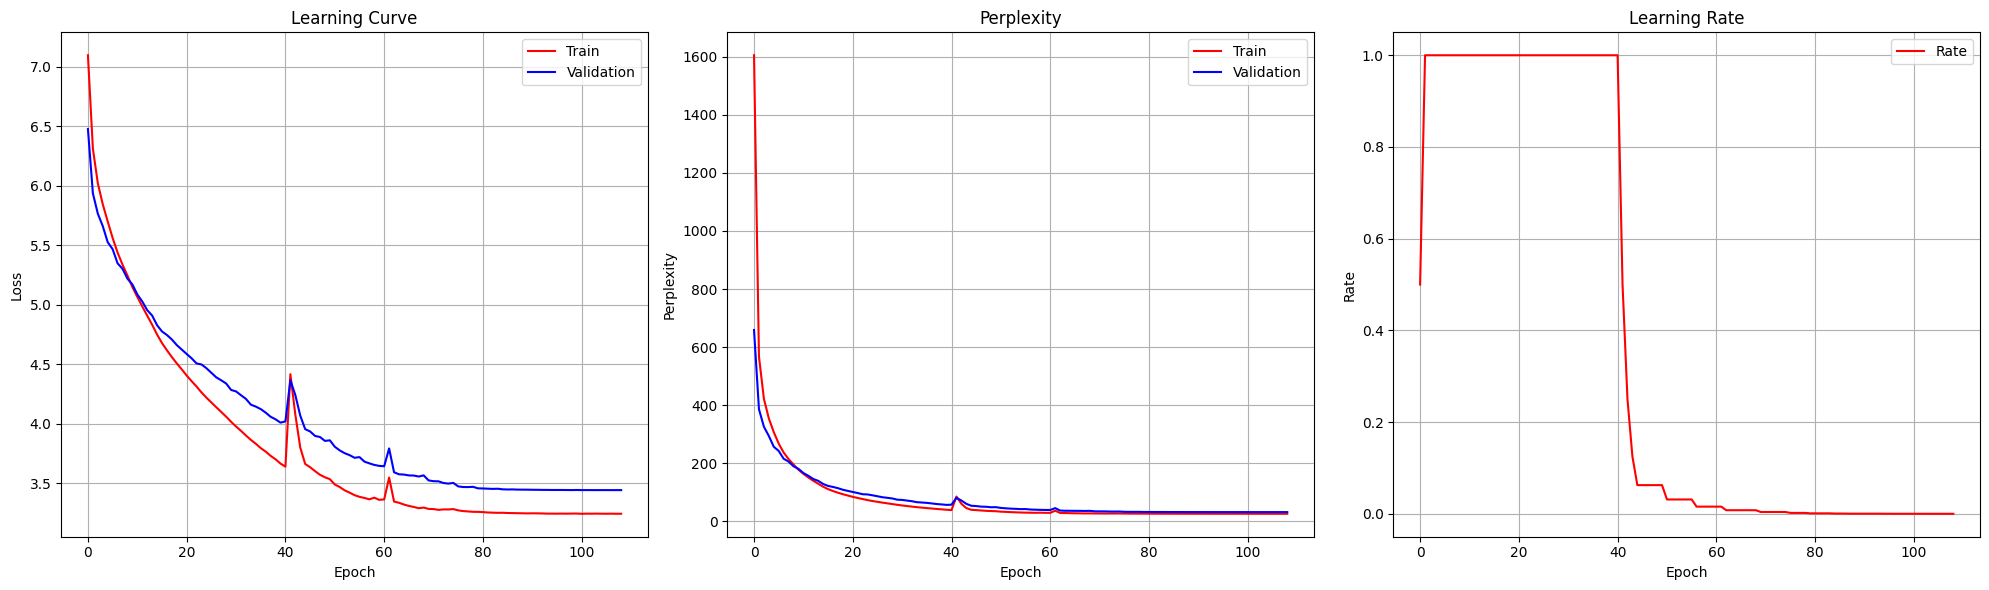

In [34]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [35]:
#LanguageModel = H_LSTM

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 3.441 , Perplexity = 32.32
Test: Loss = 3.383 , Perplexity = 31.01


# Text Generation

In [36]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H2HLSTM(
  (embedding): Embedding(28785, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=28785, bias=True)
)

In [37]:
num_trainable_params(model)

34.825785

In [69]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.6, 
                          model = model)

print(generated_text)

i think the movie for love as an second world series as one of british series awards , as well as fantasy fans of the year in 2009 and the series of fame of 2002 and the 2012 god series of fame ' s tales of france .
